# Bài tập 4 - Differential Evolution (DE) & (1+λ)-Evolution Strategies (ES)
Trong bài tập này, chúng ta cài đặt Differential Evolution (DE) và (1+λ)-Evolution Strategies (ES) để cực tiểu hóa các hàm mục tiêu sau, với d là số biến:
1. f1: **Sphere** (d=2 và d=10).
2. f2: **Griewank** (d=2 và d=10).
3. f3: **Rosenbrock** (d=2 và d=10).
4. f4: **Michalewicz** (d=2 và d=10).

Thông tin về các hàm này: công thức hàm mục tiêu, miền giá trị (search domain), và thông tin về cực trị toàn cục (global minima) các bạn tham khảo tại đây: https://www.sfu.ca/~ssurjano/optimization.html

Các bạn cần thực nghiệm như sau::
* Kích thước quần thể N (hoặc λ) là 10 (đối với d = 2) và 100 (đối với d = 10).
* Với mỗi trường hợp (f,d), các bạn cần chạy thực nghiệm 10 lần với random seed được thiết lập như sau. Gọi ABCD là 4 chữ số cuối của mã số học viên cao học. 10 random seed sẽ là từ ABCD cho đến ABCD+9.
* Mỗi lần chạy thực nghiệm thì thuật toán dừng lại ngay sau khi 100.000 lần (đối với d = 2) hoặc 1.000.000 lần (đối với d = 10) hàm đánh giá (evaluation function) được gọi thực hiện. Các bạn cần lưu lại thông tin về lời giải tốt nhất xbest và giá trị hàm mục tiêu fitness(xbest ) mà DE và (1+λ)-ES tìm ra tại mỗi thế hệ thứ i.
* Với mỗi hàm mục tiêu (f1, f2, f3, f4) và mỗi trường hợp số biến (d = 2, d = 10), các bạn cần **vẽ đồ thị kết quả của DE và ES** với đường trung bình và độ lệch chuẩn tính trên 10 lần thực nghiệm (tham khảo cách vẽ trong các slides ipynb và trong các bài tập trước). **Lưu ý**: trục x là số thế hệ và trục y là giá trị hàm mục tiêu. **Cần vẽ kết quả của DE và ES trong cùng một đồ thị** để so sánh. Chúng ta sẽ có tổng cộng 8 đồ thị kết quả.
* Các bạn cần tạo **bảng thống kê so sánh** kết quả của lời giải tốt nhất sau cùng mà DE và ES tìm được khi thuật toán kết thúc. Bảng so sánh cần có giá trị trung bình và độ lệch chuẩn tính trên 10 lần thực nghiệm.
* Các bạn có nhận xét gì về hiệu năng của DE và ES trong từng trường hợp hàm mục tiêu?

**Bài nộp**: 01 file BT4_MSSV.ipynb với MSSV là mã số học viên của các bạn. File ipynb chứa cài đặt và kết quả chạy thực nghiệm, cũng như đồ thị, bảng thống kê kết quả, và nhận xét.

In [1]:
# số lần thực nghiệm: 10
n_trials = 10

In [137]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from tqdm import tqdm
from tabulate import tabulate
np.random.seed(1039)

In [3]:
def spheref(X):
    d = len(X)
    total_sum = 0
    for i in range(d):
        xi = X[i]
        total_sum += xi ** 2

    return total_sum

In [4]:
def griewank(X):
    d = len(X)
    total_sum = 0
    total_prod = 1

    for i in range(d):
        xi = X[i]
        total_sum += xi ** 2 / 4000
        total_prod *= np.cos(xi / np.sqrt(i + 1))

    result = total_sum - total_prod + 1
    return result

In [5]:
def rosen(X):
    d = len(X)
    total_sum = 0

    for i in range(d - 1):
        xi = X[i]
        xnext = X[i + 1]
        new = 100 * (xnext - xi ** 2) ** 2 + (xi - 1) ** 2
        total_sum += new

    return total_sum

In [6]:
def michal(X, m=10):
    d = len(X)
    total_sum = 0

    for i in range(d):
        xi = X[i]
        new = np.sin(xi) * (np.sin(i * xi ** 2 / np.pi)) ** (2 * m)
        total_sum += new

    result = -total_sum
    return result

In [44]:
def differential_evolution(f, pop_init, minVal, maxVal, max_evaluations, F=0.1, CR=0.7):
    # Khởi tạo quần thể ban đầu
    pop_size = len(pop_init)
    d = len(pop_init[0])
    pop = np.copy(pop_init)  # Mỗi hàng đại diện cho một cá thể
    n_genes = int(max_evaluations/pop_size)
    pop_fitness = [f(ind) for ind in pop]
    genes_best_fitness = [] # fitness tốt nhất (min) qua từng thế hệ (genes)
    genes_best_X = [] # X tốt nhất tương ứng qua từng thế hệ (genes)

    # Chạy vòng lặp
    for i in range(n_genes):
        for j in range(pop_size):
            # Lựa chọn 3 cá thể khác nhau (index không trùng nhau)
            candidates = [idx for idx in range(pop_size) if idx != j]
            a, b, c = np.random.choice(candidates, 3, replace=False)

            # Tạo vector đột biến
            mutant = pop[a] + F * (pop[b] - pop[c])
            mutant = np.clip(mutant, minVal, maxVal)  # Đảm bảo mutant nằm trong miền giá trị

            # Tạo vector con
            crossover = np.random.rand(d) < CR
            if not np.any(crossover):  # Đảm bảo ít nhất một phần tử được chọn để crossover
                crossover[np.random.randint(0, d)] = True

            trial = np.where(crossover, mutant, pop[j])

            # Đánh giá hàm mục tiêu tại trial
            f_trial = f(trial)
            f_original = pop_fitness[j]

            # So sánh và cập nhật cá thể nếu tốt hơn
            if f_trial < f_original:
                pop[j] = trial
                pop_fitness[j] = f_trial

        best_idx = np.argmin([ind for ind in pop_fitness])
        genes_best_fitness.append(pop_fitness[best_idx])
        genes_best_X.append(pop[best_idx])

    return genes_best_X, genes_best_fitness

In [45]:
def one_plus_lambda_ES(f, pop_init, 𝜆: int, minVal, maxVal, max_evaluations, sigma = 0.1):
    # Khởi tạo quần thể ban đầu
    pop_size = len(pop_init)
    d = len(pop_init[0])
    pop = np.copy(pop_init)  # Mỗi hàng đại diện cho một cá thể
    n_genes = int(max_evaluations/(pop_size*𝜆))
    pop_fitness = [f(ind) for ind in pop]
    genes_best_fitness = [] # fitness tốt nhất (min) qua từng thế hệ (genes)
    genes_best_X = [] # X tốt nhất tương ứng qua từng thế hệ (genes)

    for i in range(n_genes):
      for j in range(pop_size):
        # Tạo 𝜆 điểm đột biến ngẫu nhiên
        mutations = [pop[j] + sigma * np.random.randn(d) for _ in range(𝜆)]
        mutations = np.clip(mutations, minVal, maxVal)

        # Đánh giá hàm mục tiêu tại điểm đột biến
        mutation_fits = [f(mutation) for mutation in mutations]

        # chọn điểm đột biến có giá trị f (fitness) nhỏ nhất
        best_mutation_idx = np.argmin([mutation_fit for mutation_fit in mutation_fits])
        best_mutation_fit = mutation_fits[best_mutation_idx]

        # So sánh và cập nhật nếu tốt hơn
        if best_mutation_fit < pop_fitness[j]:
          pop_fitness[j] = best_mutation_fit
          pop[j] = mutations[best_mutation_idx]

      best_idx = np.argmin([ind for ind in pop_fitness])
      genes_best_fitness.append(pop_fitness[best_idx])
      genes_best_X.append(pop[best_idx])
    return genes_best_X, genes_best_fitness

In [145]:

λ_values = [2, 4, 8]

# headers của table so sánh kết quả lời giải tốt nhất
headers = ['', 'DE']
for λ in λ_values:
  headers.append(f"(1+λ) λ={λ}")


# 1. F1: Sphere Function

## 1.1 Sphere Function with **d = 2**

In [146]:
population_size = 10
d = 2
max_evaluations = 10**5
minVal = -5.12
maxVal = 5.12

In [147]:
de_genes_best_X_collection_Sphere1 = [] #  10 item trial tương ứng mỗi item là danh sách best X qua từng thế hệ (genes) i
de_genes_best_fitness_collection_Sphere1 = [] # 10 item trial tương ứng mỗi item là danh sách best f qua từng thế hệ (genes) i
lambda_genes_best_X_collection_Sphere1 = [] # 10 item trial tương ứng mỗi item là 1 matrix với column 1 là λ và column 2 là danh sách best X qua từng thế hệ ứng với trial và λ
lambda_genes_best_fitness_collection_Sphere1 = [] # 10 trial tương ứng mỗi trial là 1 matrix với column 1 là λ và column 2 là danh sách best f qua từng thế hệ ứng với trial và λ

for trial in range(n_trials):
  np.random.seed(1039 + trial) # thiết lập random seed là 4 chữ số cuối MSHV + (0 - 9)
  pop_init = np.random.uniform(minVal, maxVal, size = (population_size, d)) # Khởi tạo cùng 1 quần thể cho cả DE và (1 + λ)ES

  # DE
  de_genes_best_X, de_genes_best_fitness = differential_evolution(spheref, pop_init, minVal, maxVal, max_evaluations)
  de_genes_best_X_collection_Sphere1.append(de_genes_best_X)
  de_genes_best_fitness_collection_Sphere1.append(de_genes_best_fitness)

  # (1 + λ)ES
  genes_best_X_trial = [] # Mỗi Item gồm λ và genes_best_X
  genes_best_fitness_trial = [] # Mỗi Item gồm λ và genes_best_fitness
  for λ in λ_values:
    genes_best_X, genes_best_fitness = one_plus_lambda_ES(spheref, pop_init, λ, minVal, maxVal, max_evaluations)
    genes_best_X_trial.append(genes_best_X)
    genes_best_fitness_trial.append(genes_best_fitness)
  lambda_genes_best_X_collection_Sphere1.append(genes_best_X_trial)
  lambda_genes_best_fitness_collection_Sphere1.append(genes_best_fitness_trial)


In [148]:
# DE: X best sau khi thuật toán chạy xong của 10 trials
de_best_X_Sphere1 = np.array(de_genes_best_X_collection_Sphere1)[:, -1]

# DE: Tính toán μ và σ cho đồ thị
t_DE_Sphere1 = np.array(de_genes_best_fitness_collection_Sphere1).T
print(t_DE_Sphere1.shape)
μ_DE_Sphere1 = np.mean(t_DE_Sphere1, axis= 1)
σ_DE_Sphere1 = np.std(t_DE_Sphere1, axis=1)

# (1+λ)ES: X best sau khi thuật toán chạy xong
lambda_best_X_Sphere1 = [] # Item thứ i là danh sách best X 10 trial tương ứng λ thứ i
μ_λ_Sphere1 = []
σ_λ_Sphere1 = []
for i, λ in enumerate(λ_values):
  best_X_items = [item[-1] for item in np.array(lambda_genes_best_X_collection_Sphere1)[:, i]]
  lambda_best_X_Sphere1.append(best_X_items)
  best_fitness_λ = [item for item in np.array(lambda_genes_best_fitness_collection_Sphere1)[:, i]]
  t_Lambda = np.array(best_fitness_λ).T
  μ_λ_Sphere1.append(np.mean(t_Lambda, axis=1))
  σ_λ_Sphere1.append(np.std(t_Lambda, axis=1))

(10000, 10)


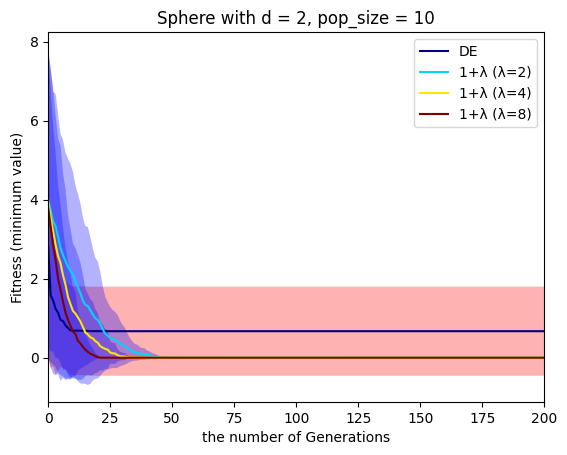

In [149]:
# Sử dụng colormap cho các giá trị 𝜆 và DE
colormap = plt.cm.get_cmap('jet', len(λ_values) + 1)

# DE
plt.plot(μ_DE_Sphere1, label='DE', color=colormap(0))
plt.fill_between(np.arange(0, len(μ_DE_Sphere1)), μ_DE_Sphere1 - σ_DE_Sphere1, μ_DE_Sphere1 + σ_DE_Sphere1, facecolor='r', alpha=0.3)

# (1 + λ)
for i , λ in enumerate(λ_values):
  color = colormap(i +1)
  label = f"1+λ (λ={λ})"
  plt.plot(μ_λ_Sphere1[i], label=label, color=color)
  plt.fill_between(np.arange(0, len(μ_λ_Sphere1[i])), μ_λ_Sphere1[i] - σ_λ_Sphere1[i], μ_λ_Sphere1[i] + σ_λ_Sphere1[i], facecolor='b', alpha=0.3)

plt.xlabel("the number of Generations")
plt.ylabel("Fitness (minimum value)")
plt.title("Sphere with d = 2, pop_size = 10")
plt.xlim(0, 200)
plt.legend()

**Nhận xét:**
- Dựa vào biểu đồ trực quan ta có thể thấy từ một quần thể khởi tạo ngẫu nhiên giống nhau bằng phương pháp tiến hóa DE cực tiểu hóa hàm Sphere tốt hơn (1+λ)ES ở một số thế hệ (genes) ban đầu. Tuy nhiên khi chạy thuật toán đủ lâu thì phương pháp (1+λ)ES sẽ cho kết quả tốt hơn DE.
- Nếu xét về thế hệ thì khi λ càng lớn thì thuật toán sẽ tối ưu nhanh hơn vì ở mỗi thế hệ thuật toán sẽ có không gian tìm kiếm lớn hơn dẫn đến tối ưu nhanh hơn. Tuy nhiên việc tìm kiếm với λ lớn cũng sẽ tiêu tốn chi phí nhiều số lần đánh giá hơn.
- Phương pháp (1+λ)ES tìm được kết quả gần với cực tiểu của hàm Sphere hơn là phương pháp DE.

In [150]:
# Bảng so sánh
data_Sphere1 = []
for trial in range(n_trials):
  itemData = [ f"trial {trial + 1}", de_best_X_Sphere1[trial] ]
  for i, λ in enumerate(λ_values):
    itemData.append(np.array(lambda_best_X_Sphere1)[i, trial])
  data_Sphere1.append(itemData)

μ_table_Sphere1 = ['μ']
σ_table_Sphere1 = ['σ']
for i in range(1, len(headers)):
   item = np.array(data_Sphere1)[:, i]
   μ_table_Sphere1.append(np.mean(item))
   σ_table_Sphere1.append(np.std(item))

data_Sphere1.append(μ_table_Sphere1)
data_Sphere1.append(σ_table_Sphere1)

table_Sphere1 = tabulate(data_Sphere1, headers=headers, tablefmt='grid')
print(table_Sphere1)

+----------+---------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+
|          | DE                              | (1+λ) λ=2                         | (1+λ) λ=4                         | (1+λ) λ=8                         |
+==========+=================================+===================================+===================================+===================================+
| trial 1  | [4.46030112e-01 3.21070054e-04] | [-1.57431212e-04 -1.07133091e-05] | [ 0.00036101 -0.00041612]         | [0.00027106 0.00012399]           |
+----------+---------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+
| trial 2  | [ 1.13284303 -0.20929881]       | [0.000356   0.00042946]           | [-4.95239129e-05  6.13211929e-05] | [ 0.00022248 -0.00028108]         |
+----------+---------------------------------+------------------------

## 1.2 Sphere Function with **d = 10**

In [151]:
population_size = 100
d = 10
max_evaluations = 10**6

In [113]:
de_genes_best_X_collection_Sphere2 = [] #  10 item trial tương ứng mỗi item là danh sách best X qua từng thế hệ (genes) i
de_genes_best_fitness_collection_Sphere2 = [] # 10 item trial tương ứng mỗi item là danh sách best f qua từng thế hệ (genes) i
lambda_genes_best_X_collection_Sphere2 = [] # 10 item trial tương ứng mỗi item là 1 matrix với column 1 là λ và column 2 là danh sách best X qua từng thế hệ ứng với trial và λ
lambda_genes_best_fitness_collection_Sphere2 = [] # 10 trial tương ứng mỗi trial là 1 matrix với column 1 là λ và column 2 là danh sách best f qua từng thế hệ ứng với trial và λ

for trial in range(n_trials):
  np.random.seed(1039 + trial) # thiết lập random seed là 4 chữ số cuối MSHV + (0 - 9)
  pop_init = np.random.uniform(minVal, maxVal, size = (population_size, d)) # Khởi tạo cùng 1 quần thể cho cả DE và (1 + λ)ES

  # DE
  de_genes_best_X, de_genes_best_fitness = differential_evolution(spheref, pop_init, minVal, maxVal, max_evaluations)
  de_genes_best_X_collection_Sphere2.append(de_genes_best_X)
  de_genes_best_fitness_collection_Sphere2.append(de_genes_best_fitness)

  # (1 + λ)ES
  genes_best_X_trial = [] # Mỗi Item gồm λ và genes_best_X
  genes_best_fitness_trial = [] # Mỗi Item gồm λ và genes_best_fitness
  for λ in λ_values:
    genes_best_X, genes_best_fitness = one_plus_lambda_ES(spheref, pop_init, λ, minVal, maxVal, max_evaluations)
    genes_best_X_trial.append(genes_best_X)
    genes_best_fitness_trial.append(genes_best_fitness)
  lambda_genes_best_X_collection_Sphere2.append(genes_best_X_trial)
  lambda_genes_best_fitness_collection_Sphere2.append(genes_best_fitness_trial)

In [152]:
# DE: X best sau khi thuật toán chạy xong của 10 trials
de_best_X_Sphere2 = np.array(de_genes_best_X_collection_Sphere2)[:, -1]

# DE: Tính toán μ và σ cho đồ thị
t_DE_Sphere2 = np.array(de_genes_best_fitness_collection_Sphere2).T
print(t_DE_Sphere2.shape)
μ_DE_Sphere2 = np.mean(t_DE_Sphere2, axis= 1)
σ_DE_Sphere2 = np.std(t_DE_Sphere2, axis=1)

# (1+λ)ES: X best sau khi thuật toán chạy xong
lambda_best_X_Sphere2 = [] # Item thứ i là danh sách best X 10 trial tương ứng λ thứ i
μ_λ_Sphere2 = []
σ_λ_Sphere2 = []
for i, λ in enumerate(λ_values):
  best_X_items = [item[-1] for item in np.array(lambda_genes_best_X_collection_Sphere2)[:, i]]
  lambda_best_X_Sphere2.append(best_X_items)
  best_fitness_λ = [item for item in np.array(lambda_genes_best_fitness_collection_Sphere2)[:, i]]
  t_Lambda = np.array(best_fitness_λ).T
  μ_λ_Sphere2.append(np.mean(t_Lambda, axis=1))
  σ_λ_Sphere2.append(np.std(t_Lambda, axis=1))

(10000, 10)


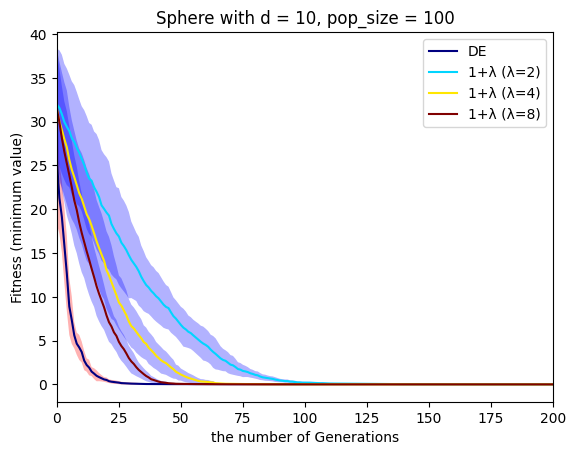

In [153]:
# Sử dụng colormap cho các giá trị 𝜆 và DE
colormap = plt.cm.get_cmap('jet', len(λ_values) + 1)

# DE
plt.plot(μ_DE_Sphere2, label='DE', color=colormap(0))
plt.fill_between(np.arange(0, len(μ_DE_Sphere2)), μ_DE_Sphere2 - σ_DE_Sphere2, μ_DE_Sphere2 + σ_DE_Sphere2, facecolor='r', alpha=0.3)

# (1 + λ)
for i , λ in enumerate(λ_values):
  color = colormap(i +1)
  label = f"1+λ (λ={λ})"
  plt.plot(μ_λ_Sphere2[i], label=label, color=color)
  plt.fill_between(np.arange(0, len(μ_λ_Sphere2[i])), μ_λ_Sphere2[i] - σ_λ_Sphere2[i], μ_λ_Sphere2[i] + σ_λ_Sphere2[i], facecolor='b', alpha=0.3)

plt.xlabel("the number of Generations")
plt.ylabel("Fitness (minimum value)")
plt.title("Sphere with d = 10, pop_size = 100")
plt.xlim(0, 200)
plt.legend()

**Nhận xét:**
- Khi tăng kích thướt quần thể (pop_size = 10) và kích thướt cá thể (d =10) có thể thấy kết quả tối ưu khi thuật toán chạy xong của DE và (1+λ)ES là xấp xĩ nhau.  
- Tuy nhiên về hiệu năng thì phương pháp DE đạt được trạng thái tối ưu nhanh hơn (1+λ)ES cả về số thế hệ (genes) và số lần sử dụng hàm đánh giá.

In [154]:
# Bảng so sánh
data_Sphere2 = []
for trial in range(n_trials):
  itemData = [ f"trial {trial + 1}", de_best_X_Sphere2[trial] ]
  for i, λ in enumerate(λ_values):
    itemData.append(np.array(lambda_best_X_Sphere2)[i, trial])
  data_Sphere2.append(itemData)

μ_table_Sphere2 = ['μ']
σ_table_Sphere2 = ['σ']
for i in range(1, len(headers)):
   item = np.array(data_Sphere2)[:, i]
   μ_table_Sphere2.append(np.mean(item))
   σ_table_Sphere2.append(np.std(item))

data_Sphere2.append(μ_table_Sphere2)
data_Sphere2.append(σ_table_Sphere2)

table_Sphere2 = tabulate(data_Sphere2, headers=headers, tablefmt='grid')
print(table_Sphere2)

+----------+------------------------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+
|          | DE                                                               | (1+λ) λ=2                                                                | (1+λ) λ=4                                                                | (1+λ) λ=8                                                                |
+==========+==================================================================+==========================================================================+==========================================================================+==========================================================================+
| trial 1  | [ 2.73883338e-13  2.21079426e-09 -1.02010881e-08  1.32387761e-12 | [-0.0

# 2. F2: Griewank Function

## 2.1 Griewank Function with **d = 2**

In [156]:
population_size = 10
d = 2
max_evaluations = 10**5
minVal = -600
maxVal = 600

In [157]:
de_genes_best_X_collection_Griewank1 = [] #  10 item trial tương ứng mỗi item là danh sách best X qua từng thế hệ (genes) i
de_genes_best_fitness_collection_Griewank1 = [] # 10 item trial tương ứng mỗi item là danh sách best f qua từng thế hệ (genes) i
lambda_genes_best_X_collection_Griewank1 = [] # 10 item trial tương ứng mỗi item là 1 matrix với column 1 là λ và column 2 là danh sách best X qua từng thế hệ ứng với trial và λ
lambda_genes_best_fitness_collection_Griewank1 = [] # 10 trial tương ứng mỗi trial là 1 matrix với column 1 là λ và column 2 là danh sách best f qua từng thế hệ ứng với trial và λ

for trial in range(n_trials):
  np.random.seed(1039 + trial) # thiết lập random seed là 4 chữ số cuối MSHV + (0 - 9)
  pop_init = np.random.uniform(minVal, maxVal, size = (population_size, d)) # Khởi tạo cùng 1 quần thể cho cả DE và (1 + λ)ES

  # DE
  de_genes_best_X, de_genes_best_fitness = differential_evolution(griewank, pop_init, minVal, maxVal, max_evaluations)
  de_genes_best_X_collection_Griewank1.append(de_genes_best_X)
  de_genes_best_fitness_collection_Griewank1.append(de_genes_best_fitness)

  # (1 + λ)ES
  genes_best_X_trial = [] # Mỗi Item gồm λ và genes_best_X
  genes_best_fitness_trial = [] # Mỗi Item gồm λ và genes_best_fitness
  for λ in λ_values:
    genes_best_X, genes_best_fitness = one_plus_lambda_ES(griewank, pop_init, λ, minVal, maxVal, max_evaluations)
    genes_best_X_trial.append(genes_best_X)
    genes_best_fitness_trial.append(genes_best_fitness)
  lambda_genes_best_X_collection_Griewank1.append(genes_best_X_trial)
  lambda_genes_best_fitness_collection_Griewank1.append(genes_best_fitness_trial)

# DE: X best sau khi thuật toán chạy xong của 10 trials
de_best_X_Griewank1 = np.array(de_genes_best_X_collection_Griewank1)[:, -1]

# DE: Tính toán μ và σ cho đồ thị
t_DE_Griewank1 = np.array(de_genes_best_fitness_collection_Griewank1).T
μ_DE_Griewank1 = np.mean(t_DE_Griewank1, axis= 1)
σ_DE_Griewank1 = np.std(t_DE_Griewank1, axis=1)

# (1+λ)ES: X best sau khi thuật toán chạy xong
lambda_best_X_Griewank1 = [] # Item thứ i là danh sách best X 10 trial tương ứng λ thứ i
μ_λ_Griewank1 = []
σ_λ_Griewank1 = []
for i, λ in enumerate(λ_values):
  best_X_items = [item[-1] for item in np.array(lambda_genes_best_X_collection_Griewank1)[:, i]]
  lambda_best_X_Griewank1.append(best_X_items)
  best_fitness_λ = [item for item in np.array(lambda_genes_best_fitness_collection_Griewank1)[:, i]]
  t_Lambda = np.array(best_fitness_λ).T
  μ_λ_Griewank1.append(np.mean(t_Lambda, axis=1))
  σ_λ_Griewank1.append(np.std(t_Lambda, axis=1))

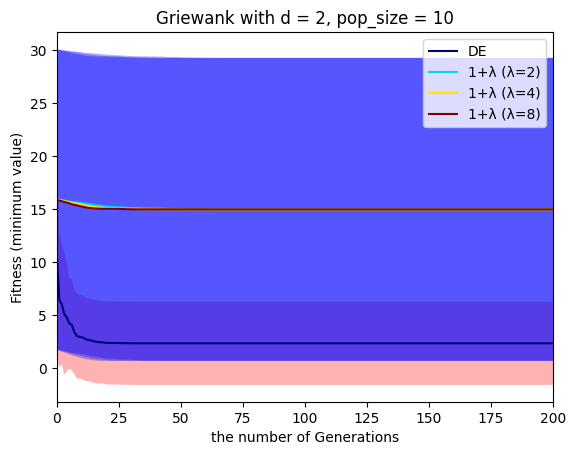

In [158]:
# Sử dụng colormap cho các giá trị 𝜆 và DE
colormap = plt.cm.get_cmap('jet', len(λ_values) + 1)

# DE
plt.plot(μ_DE_Griewank1, label='DE', color=colormap(0))
plt.fill_between(np.arange(0, len(μ_DE_Griewank1)), μ_DE_Griewank1 - σ_DE_Griewank1, μ_DE_Griewank1 + σ_DE_Griewank1, facecolor='r', alpha=0.3)

# (1 + λ)
for i , λ in enumerate(λ_values):
  color = colormap(i +1)
  label = f"1+λ (λ={λ})"
  plt.plot(μ_λ_Griewank1[i], label=label, color=color)
  plt.fill_between(np.arange(0, len(μ_λ_Griewank1[i])), μ_λ_Griewank1[i] - σ_λ_Griewank1[i], μ_λ_Griewank1[i] + σ_λ_Griewank1[i], facecolor='b', alpha=0.3)

plt.xlabel("the number of Generations")
plt.ylabel("Fitness (minimum value)")
plt.title("Griewank with d = 2, pop_size = 10")
plt.xlim(0, 200)
plt.legend()

**Nhận xét:**
- Cực tiếu hóa hàm Griewanh bằng phương pháp DE sẽ cho kết quả tốt hơn nhiều so với phương pháp (1+λ)ES.
- Tuy nhiên kết quả tối ưu khi tìm được lời giải bằng cả 2 phương pháp đều cách rất xa so với lời giải tối ưu của hàm Griewank.

In [159]:
# Bảng so sánh
data_Griewank1 = []
for trial in range(n_trials):
  itemData = [ f"trial {trial + 1}", de_best_X_Griewank1[trial] ]
  for i, λ in enumerate(λ_values):
    itemData.append(np.array(lambda_best_X_Griewank1)[i, trial])
  data_Griewank1.append(itemData)

μ_table_Griewank1 = ['μ']
σ_table_Griewank1 = ['σ']
for i in range(1, len(headers)):
   item = np.array(data_Griewank1)[:, i]
   μ_table_Griewank1.append(np.mean(item))
   σ_table_Griewank1.append(np.std(item))

data_Griewank1.append(μ_table_Griewank1)
data_Griewank1.append(σ_table_Griewank1)

table_Griewank1 = tabulate(data_Griewank1, headers=headers, tablefmt='grid')
print(table_Griewank1)

+----------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|          | DE                            | (1+λ) λ=2                     | (1+λ) λ=4                     | (1+λ) λ=8                     |
+==========+===============================+===============================+===============================+===============================+
| trial 1  | [-37.62768906  17.64056006]   | [113.03973067  53.26184526]   | [113.04025323  53.26106415]   | [113.04099479  53.25957197]   |
+----------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
| trial 2  | [131.88741741 -26.53957993]   | [-153.85883844  332.87932158] | [-153.85839799  332.88005225] | [-153.85794923  332.87788561] |
+----------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
| trial 3  | 

## 2.2 Griewank Function with **d = 10**

In [160]:
population_size = 100
d = 10
max_evaluations = 10**6

In [161]:
de_genes_best_X_collection_Griewank2 = [] #  10 item trial tương ứng mỗi item là danh sách best X qua từng thế hệ (genes) i
de_genes_best_fitness_collection_Griewank2 = [] # 10 item trial tương ứng mỗi item là danh sách best f qua từng thế hệ (genes) i
lambda_genes_best_X_collection_Griewank2 = [] # 10 item trial tương ứng mỗi item là 1 matrix với column 1 là λ và column 2 là danh sách best X qua từng thế hệ ứng với trial và λ
lambda_genes_best_fitness_collection_Griewank2 = [] # 10 trial tương ứng mỗi trial là 1 matrix với column 1 là λ và column 2 là danh sách best f qua từng thế hệ ứng với trial và λ

for trial in range(n_trials):
  np.random.seed(1039 + trial) # thiết lập random seed là 4 chữ số cuối MSHV + (0 - 9)
  pop_init = np.random.uniform(minVal, maxVal, size = (population_size, d)) # Khởi tạo cùng 1 quần thể cho cả DE và (1 + λ)ES

  # DE
  de_genes_best_X, de_genes_best_fitness = differential_evolution(griewank, pop_init, minVal, maxVal, max_evaluations)
  de_genes_best_X_collection_Griewank2.append(de_genes_best_X)
  de_genes_best_fitness_collection_Griewank2.append(de_genes_best_fitness)

  # (1 + λ)ES
  genes_best_X_trial = [] # Mỗi Item gồm λ và genes_best_X
  genes_best_fitness_trial = [] # Mỗi Item gồm λ và genes_best_fitness
  for λ in λ_values:
    genes_best_X, genes_best_fitness = one_plus_lambda_ES(griewank, pop_init, λ, minVal, maxVal, max_evaluations)
    genes_best_X_trial.append(genes_best_X)
    genes_best_fitness_trial.append(genes_best_fitness)
  lambda_genes_best_X_collection_Griewank2.append(genes_best_X_trial)
  lambda_genes_best_fitness_collection_Griewank2.append(genes_best_fitness_trial)

# DE: X best sau khi thuật toán chạy xong của 10 trials
de_best_X_Griewank2 = np.array(de_genes_best_X_collection_Griewank2)[:, -1]

# DE: Tính toán μ và σ cho đồ thị
t_DE_Griewank2 = np.array(de_genes_best_fitness_collection_Griewank2).T
print(t_DE_Griewank2.shape)
μ_DE_Griewank2 = np.mean(t_DE_Griewank2, axis= 1)
σ_DE_Griewank2 = np.std(t_DE_Griewank2, axis=1)

# (1+λ)ES: X best sau khi thuật toán chạy xong
lambda_best_X_Griewank2 = [] # Item thứ i là danh sách best X 10 trial tương ứng λ thứ i
μ_λ_Griewank2 = []
σ_λ_Griewank2 = []
for i, λ in enumerate(λ_values):
  best_X_items = [item[-1] for item in np.array(lambda_genes_best_X_collection_Griewank2)[:, i]]
  lambda_best_X_Griewank2.append(best_X_items)
  best_fitness_λ = [item for item in np.array(lambda_genes_best_fitness_collection_Griewank2)[:, i]]
  t_Lambda = np.array(best_fitness_λ).T
  μ_λ_Griewank2.append(np.mean(t_Lambda, axis=1))
  σ_λ_Griewank2.append(np.std(t_Lambda, axis=1))

(10000, 10)


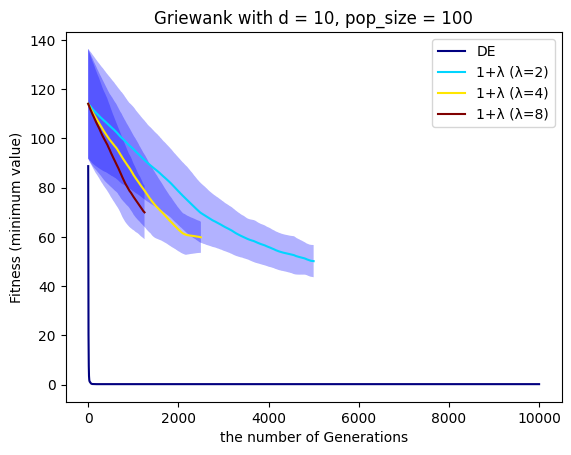

In [176]:
# Sử dụng colormap cho các giá trị 𝜆 và DE
colormap = plt.cm.get_cmap('jet', len(λ_values) + 1)

# DE
plt.plot(μ_DE_Griewank2, label='DE', color=colormap(0))
plt.fill_between(np.arange(0, len(μ_DE_Griewank2)), μ_DE_Griewank2 - σ_DE_Griewank2, μ_DE_Griewank2 + σ_DE_Griewank2, facecolor='r', alpha=0.3)

# (1 + λ)
for i , λ in enumerate(λ_values):
  color = colormap(i +1)
  label = f"1+λ (λ={λ})"
  plt.plot(μ_λ_Griewank2[i], label=label, color=color)
  plt.fill_between(np.arange(0, len(μ_λ_Griewank2[i])), μ_λ_Griewank2[i] - σ_λ_Griewank2[i], μ_λ_Griewank2[i] + σ_λ_Griewank2[i], facecolor='b', alpha=0.3)

plt.xlabel("the number of Generations")
plt.ylabel("Fitness (minimum value)")
plt.title("Griewank with d = 10, pop_size = 100")
#plt.xlim(0, 2000)
plt.legend()
griewank_chart_1 = plt.gcf()

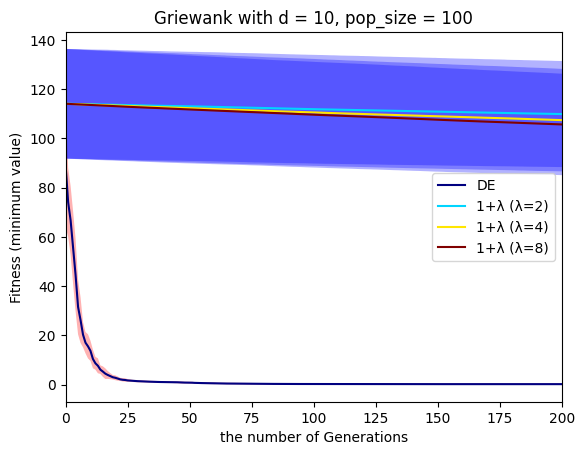

In [177]:
griewank_chart_1.gca().set_xlim(0, 200)
#griewank_chart_1.gca().set_ylim(0, 5)
griewank_chart_1

**Nhận xét:**
- Phương pháp DE tìm được lời giả gần với lời giải tối ưu (cực tiểu) nhanh hơn rất nhiều so với phương pháp (1+λ)ES.
- Khi sử dụng phương pháp (1+λ)ES để cự tiểu hóa hàm Griewank thì tốc độ tối ưu là chậm và sau khi chạy xong (hết 1.000.000 lần đánh giá) thì kết quả tìm được vẫn cách rất xa so với kết quả tối ưu (cực tiểu) mong đợi.

In [178]:
# Bảng so sánh
data_Griewank2 = []
for trial in range(n_trials):
  itemData = [ f"trial {trial + 1}", de_best_X_Griewank2[trial] ]
  for i, λ in enumerate(λ_values):
    itemData.append(np.array(lambda_best_X_Griewank2)[i, trial])
  data_Griewank2.append(itemData)

μ_table_Griewank2 = ['μ']
σ_table_Griewank2 = ['σ']
for i in range(1, len(headers)):
   item = np.array(data_Griewank2)[:, i]
   μ_table_Griewank2.append(np.mean(item))
   σ_table_Griewank2.append(np.std(item))

data_Griewank2.append(μ_table_Griewank2)
data_Griewank2.append(σ_table_Griewank2)

table_Griewank2 = tabulate(data_Griewank2, headers=headers, tablefmt='grid')
print(table_Griewank2)

+----------+------------------------------------------------------------------+-------------------------------------------------------------------------+-------------------------------------------------------------------------+-------------------------------------------------------------------------+
|          | DE                                                               | (1+λ) λ=2                                                               | (1+λ) λ=4                                                               | (1+λ) λ=8                                                               |
+==========+==================================================================+=========================================================================+=========================================================================+=========================================================================+
| trial 1  | [ 9.84322072e-07 -6.29177215e-05 -1.77437823e-09 -2.46756292e-09 | [ 170.64570818

# 3. F3: Rosenbrock Function

# 3.1 Rosenbrock Function with **d = 2**

In [179]:
population_size = 10
d = 2
max_evaluations = 10**5
minVal = -5
maxVal = 10

In [180]:
de_genes_best_X_collection_Rosen1 = [] #  10 item trial tương ứng mỗi item là danh sách best X qua từng thế hệ (genes) i
de_genes_best_fitness_collection_Rosen1 = [] # 10 item trial tương ứng mỗi item là danh sách best f qua từng thế hệ (genes) i
lambda_genes_best_X_collection_Rosen1 = [] # 10 item trial tương ứng mỗi item là 1 matrix với column 1 là λ và column 2 là danh sách best X qua từng thế hệ ứng với trial và λ
lambda_genes_best_fitness_collection_Rosen1 = [] # 10 trial tương ứng mỗi trial là 1 matrix với column 1 là λ và column 2 là danh sách best f qua từng thế hệ ứng với trial và λ

for trial in range(n_trials):
  np.random.seed(1039 + trial) # thiết lập random seed là 4 chữ số cuối MSHV + (0 - 9)
  pop_init = np.random.uniform(minVal, maxVal, size = (population_size, d)) # Khởi tạo cùng 1 quần thể cho cả DE và (1 + λ)ES

  # DE
  de_genes_best_X, de_genes_best_fitness = differential_evolution(rosen, pop_init, minVal, maxVal, max_evaluations)
  de_genes_best_X_collection_Rosen1.append(de_genes_best_X)
  de_genes_best_fitness_collection_Rosen1.append(de_genes_best_fitness)

  # (1 + λ)ES
  genes_best_X_trial = [] # Mỗi Item gồm λ và genes_best_X
  genes_best_fitness_trial = [] # Mỗi Item gồm λ và genes_best_fitness
  for λ in λ_values:
    genes_best_X, genes_best_fitness = one_plus_lambda_ES(rosen, pop_init, λ, minVal, maxVal, max_evaluations)
    genes_best_X_trial.append(genes_best_X)
    genes_best_fitness_trial.append(genes_best_fitness)
  lambda_genes_best_X_collection_Rosen1.append(genes_best_X_trial)
  lambda_genes_best_fitness_collection_Rosen1.append(genes_best_fitness_trial)

# DE: X best sau khi thuật toán chạy xong của 10 trials
de_best_X_Rosen1 = np.array(de_genes_best_X_collection_Rosen1)[:, -1]

# DE: Tính toán μ và σ cho đồ thị
t_DE_Rosen1 = np.array(de_genes_best_fitness_collection_Rosen1).T
print(t_DE_Rosen1.shape)
μ_DE_Rosen1 = np.mean(t_DE_Rosen1, axis= 1)
σ_DE_Rosen1 = np.std(t_DE_Rosen1, axis=1)

# (1+λ)ES: X best sau khi thuật toán chạy xong
lambda_best_X_Rosen1 = [] # Item thứ i là danh sách best X 10 trial tương ứng λ thứ i
μ_λ_Rosen1 = []
σ_λ_Rosen1 = []
for i, λ in enumerate(λ_values):
  best_X_items = [item[-1] for item in np.array(lambda_genes_best_X_collection_Rosen1)[:, i]]
  lambda_best_X_Rosen1.append(best_X_items)
  best_fitness_λ = [item for item in np.array(lambda_genes_best_fitness_collection_Rosen1)[:, i]]
  t_Lambda = np.array(best_fitness_λ).T
  μ_λ_Rosen1.append(np.mean(t_Lambda, axis=1))
  σ_λ_Rosen1.append(np.std(t_Lambda, axis=1))

(10000, 10)


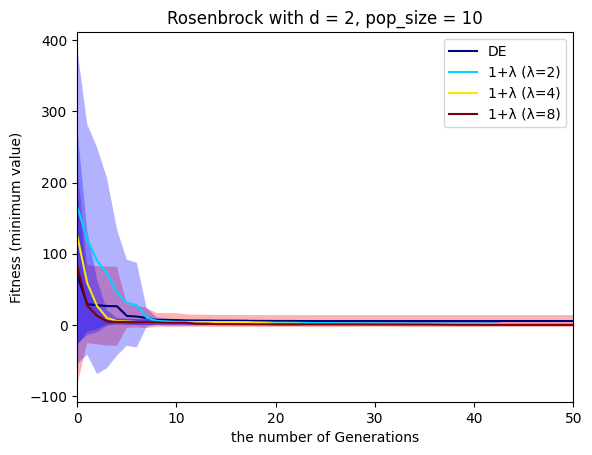

In [183]:
# Sử dụng colormap cho các giá trị 𝜆 và DE
colormap = plt.cm.get_cmap('jet', len(λ_values) + 1)

# DE
plt.plot(μ_DE_Rosen1, label='DE', color=colormap(0))
plt.fill_between(np.arange(0, len(μ_DE_Rosen1)), μ_DE_Rosen1 - σ_DE_Rosen1, μ_DE_Rosen1 + σ_DE_Rosen1, facecolor='r', alpha=0.3)

# (1 + λ)
for i , λ in enumerate(λ_values):
  color = colormap(i +1)
  label = f"1+λ (λ={λ})"
  plt.plot(μ_λ_Rosen1[i], label=label, color=color)
  plt.fill_between(np.arange(0, len(μ_λ_Rosen1[i])), μ_λ_Rosen1[i] - σ_λ_Rosen1[i], μ_λ_Rosen1[i] + σ_λ_Rosen1[i], facecolor='b', alpha=0.3)

plt.xlabel("the number of Generations")
plt.ylabel("Fitness (minimum value)")
plt.title("Rosenbrock with d = 2, pop_size = 10")
plt.xlim(0, 50)
plt.legend()

**Nhận xét:**
- Hiệu suất tối ưu (cực tiểu) qua từng thế hệ của hàm **Rosenbrock** khi sử dụng phương pháp DE và (1+λ)ES là tương đương nhau.

In [182]:
# Bảng so sánh
data_Rosen1 = []
for trial in range(n_trials):
  itemData = [ f"trial {trial + 1}", de_best_X_Rosen1[trial] ]
  for i, λ in enumerate(λ_values):
    itemData.append(np.array(lambda_best_X_Rosen1)[i, trial])
  data_Rosen1.append(itemData)

μ_table_Rosen1 = ['μ']
σ_table_Rosen1 = ['σ']
for i in range(1, len(headers)):
   item = np.array(data_Rosen1)[:, i]
   μ_table_Rosen1.append(np.mean(item))
   σ_table_Rosen1.append(np.std(item))

data_Rosen1.append(μ_table_Rosen1)
data_Rosen1.append(σ_table_Rosen1)

table_Rosen1 = tabulate(data_Rosen1, headers=headers, tablefmt='grid')
print(table_Rosen1)

+----------+---------------------------+-------------------------+-------------------------+-------------------------+
|          | DE                        | (1+λ) λ=2               | (1+λ) λ=4               | (1+λ) λ=8               |
+==========+===========================+=========================+=========================+=========================+
| trial 1  | [1.30440101 1.70329283]   | [1.00030449 1.00050541] | [0.99944038 0.99888438] | [1.00042134 1.00072255] |
+----------+---------------------------+-------------------------+-------------------------+-------------------------+
| trial 2  | [-1.58474624  2.51759791] | [0.99840456 0.99695281] | [1.00188886 1.00373783] | [0.99998883 1.00002315] |
+----------+---------------------------+-------------------------+-------------------------+-------------------------+
| trial 3  | [-0.07020222  0.01642154] | [0.99852987 0.99691693] | [0.99934957 0.99870557] | [0.99983115 0.99985553] |
+----------+---------------------------+--------

# 3.2 Rosenbrock Function with **d = 10**

In [184]:
population_size = 100
d = 10
max_evaluations = 10**6

In [185]:
de_genes_best_X_collection_Rosen2 = [] #  10 item trial tương ứng mỗi item là danh sách best X qua từng thế hệ (genes) i
de_genes_best_fitness_collection_Rosen2 = [] # 10 item trial tương ứng mỗi item là danh sách best f qua từng thế hệ (genes) i
lambda_genes_best_X_collection_Rosen2 = [] # 10 item trial tương ứng mỗi item là 1 matrix với column 1 là λ và column 2 là danh sách best X qua từng thế hệ ứng với trial và λ
lambda_genes_best_fitness_collection_Rosen2 = [] # 10 trial tương ứng mỗi trial là 1 matrix với column 1 là λ và column 2 là danh sách best f qua từng thế hệ ứng với trial và λ

for trial in range(n_trials):
  np.random.seed(1039 + trial) # thiết lập random seed là 4 chữ số cuối MSHV + (0 - 9)
  pop_init = np.random.uniform(minVal, maxVal, size = (population_size, d)) # Khởi tạo cùng 1 quần thể cho cả DE và (1 + λ)ES

  # DE
  de_genes_best_X, de_genes_best_fitness = differential_evolution(rosen, pop_init, minVal, maxVal, max_evaluations)
  de_genes_best_X_collection_Rosen2.append(de_genes_best_X)
  de_genes_best_fitness_collection_Rosen2.append(de_genes_best_fitness)

  # (1 + λ)ES
  genes_best_X_trial = [] # Mỗi Item gồm λ và genes_best_X
  genes_best_fitness_trial = [] # Mỗi Item gồm λ và genes_best_fitness
  for λ in λ_values:
    genes_best_X, genes_best_fitness = one_plus_lambda_ES(rosen, pop_init, λ, minVal, maxVal, max_evaluations)
    genes_best_X_trial.append(genes_best_X)
    genes_best_fitness_trial.append(genes_best_fitness)
  lambda_genes_best_X_collection_Rosen2.append(genes_best_X_trial)
  lambda_genes_best_fitness_collection_Rosen2.append(genes_best_fitness_trial)

# DE: X best sau khi thuật toán chạy xong của 10 trials
de_best_X_Rosen2 = np.array(de_genes_best_X_collection_Rosen2)[:, -1]

# DE: Tính toán μ và σ cho đồ thị
t_DE_Rosen2 = np.array(de_genes_best_fitness_collection_Rosen2).T
print(t_DE_Rosen2.shape)
μ_DE_Rosen2 = np.mean(t_DE_Rosen2, axis= 1)
σ_DE_Rosen2 = np.std(t_DE_Rosen2, axis=1)

# (1+λ)ES: X best sau khi thuật toán chạy xong
lambda_best_X_Rosen2 = [] # Item thứ i là danh sách best X 10 trial tương ứng λ thứ i
μ_λ_Rosen2 = []
σ_λ_Rosen2 = []
for i, λ in enumerate(λ_values):
  best_X_items = [item[-1] for item in np.array(lambda_genes_best_X_collection_Rosen2)[:, i]]
  lambda_best_X_Rosen2.append(best_X_items)
  best_fitness_λ = [item for item in np.array(lambda_genes_best_fitness_collection_Rosen2)[:, i]]
  t_Lambda = np.array(best_fitness_λ).T
  μ_λ_Rosen2.append(np.mean(t_Lambda, axis=1))
  σ_λ_Rosen2.append(np.std(t_Lambda, axis=1))

(10000, 10)


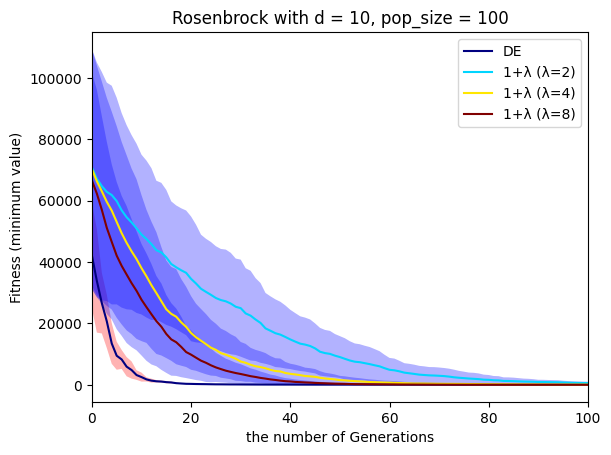

In [188]:
# Sử dụng colormap cho các giá trị 𝜆 và DE
colormap = plt.cm.get_cmap('jet', len(λ_values) + 1)

# DE
plt.plot(μ_DE_Rosen2, label='DE', color=colormap(0))
plt.fill_between(np.arange(0, len(μ_DE_Rosen2)), μ_DE_Rosen2 - σ_DE_Rosen2, μ_DE_Rosen2 + σ_DE_Rosen2, facecolor='r', alpha=0.3)

# (1 + λ)
for i , λ in enumerate(λ_values):
  color = colormap(i +1)
  label = f"1+λ (λ={λ})"
  plt.plot(μ_λ_Rosen2[i], label=label, color=color)
  plt.fill_between(np.arange(0, len(μ_λ_Rosen2[i])), μ_λ_Rosen2[i] - σ_λ_Rosen2[i], μ_λ_Rosen2[i] + σ_λ_Rosen2[i], facecolor='b', alpha=0.3)

plt.xlabel("the number of Generations")
plt.ylabel("Fitness (minimum value)")
plt.title("Rosenbrock with d = 10, pop_size = 100")
plt.xlim(0, 100)
plt.legend()

**Nhận xét:**
- Cả 2 phương pháp đều tìm được kết quả gần giống nhau và gần giống với kết quả tối ưu.
- Khi tăng kích thướt quần thể (pop_size) và số chiều (d) để tìm lời giải tối ưu(cực tiểu) của hàm Rosenbrock. Phương pháp DE biểu hiện rõ sự hiệu quả hơn phương pháp (1+λ)ES.

In [187]:
# Bảng so sánh
data_Rosen2 = []
for trial in range(n_trials):
  itemData = [ f"trial {trial + 1}", de_best_X_Rosen2[trial] ]
  for i, λ in enumerate(λ_values):
    itemData.append(np.array(lambda_best_X_Rosen2)[i, trial])
  data_Rosen2.append(itemData)

μ_table_Rosen2 = ['μ']
σ_table_Rosen2 = ['σ']
for i in range(1, len(headers)):
   item = np.array(data_Rosen2)[:, i]
   μ_table_Rosen2.append(np.mean(item))
   σ_table_Rosen2.append(np.std(item))

data_Rosen2.append(μ_table_Rosen2)
data_Rosen2.append(σ_table_Rosen2)

table_Rosen2 = tabulate(data_Rosen2, headers=headers, tablefmt='grid')
print(table_Rosen2)

+----------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+
|          | DE                                                                       | (1+λ) λ=2                                                                | (1+λ) λ=4                                                                | (1+λ) λ=8                                                                |
+==========+==========================================================================+==========================================================================+==========================================================================+==========================================================================+
| trial 1  | [-0.81155434  0.73039296  0.6690328   0.63976897

# 4. F4: Michalewicz Function

# 4.1 Michalewicz Function with **d = 2**

In [189]:
population_size = 10
d = 2
max_evaluations = 10**5
minVal = -5
maxVal = math.pi

In [190]:
de_genes_best_X_collection_Michal1 = [] #  10 item trial tương ứng mỗi item là danh sách best X qua từng thế hệ (genes) i
de_genes_best_fitness_collection_Michal1 = [] # 10 item trial tương ứng mỗi item là danh sách best f qua từng thế hệ (genes) i
lambda_genes_best_X_collection_Michal1 = [] # 10 item trial tương ứng mỗi item là 1 matrix với column 1 là λ và column 2 là danh sách best X qua từng thế hệ ứng với trial và λ
lambda_genes_best_fitness_collection_Michal1 = [] # 10 trial tương ứng mỗi trial là 1 matrix với column 1 là λ và column 2 là danh sách best f qua từng thế hệ ứng với trial và λ

for trial in range(n_trials):
  np.random.seed(1039 + trial) # thiết lập random seed là 4 chữ số cuối MSHV + (0 - 9)
  pop_init = np.random.uniform(minVal, maxVal, size = (population_size, d)) # Khởi tạo cùng 1 quần thể cho cả DE và (1 + λ)ES

  # DE
  de_genes_best_X, de_genes_best_fitness = differential_evolution(michal, pop_init, minVal, maxVal, max_evaluations)
  de_genes_best_X_collection_Michal1.append(de_genes_best_X)
  de_genes_best_fitness_collection_Michal1.append(de_genes_best_fitness)

  # (1 + λ)ES
  genes_best_X_trial = [] # Mỗi Item gồm λ và genes_best_X
  genes_best_fitness_trial = [] # Mỗi Item gồm λ và genes_best_fitness
  for λ in λ_values:
    genes_best_X, genes_best_fitness = one_plus_lambda_ES(michal, pop_init, λ, minVal, maxVal, max_evaluations)
    genes_best_X_trial.append(genes_best_X)
    genes_best_fitness_trial.append(genes_best_fitness)
  lambda_genes_best_X_collection_Michal1.append(genes_best_X_trial)
  lambda_genes_best_fitness_collection_Michal1.append(genes_best_fitness_trial)

# DE: X best sau khi thuật toán chạy xong của 10 trials
de_best_X_Michal1 = np.array(de_genes_best_X_collection_Michal1)[:, -1]

# DE: Tính toán μ và σ cho đồ thị
t_DE_Michal1 = np.array(de_genes_best_fitness_collection_Michal1).T
print(t_DE_Michal1.shape)
μ_DE_Michal1 = np.mean(t_DE_Michal1, axis= 1)
σ_DE_Michal1 = np.std(t_DE_Michal1, axis=1)

# (1+λ)ES: X best sau khi thuật toán chạy xong
lambda_best_X_Michal1 = [] # Item thứ i là danh sách best X 10 trial tương ứng λ thứ i
μ_λ_Michal1 = []
σ_λ_Michal1 = []
for i, λ in enumerate(λ_values):
  best_X_items = [item[-1] for item in np.array(lambda_genes_best_X_collection_Michal1)[:, i]]
  lambda_best_X_Michal1.append(best_X_items)
  best_fitness_λ = [item for item in np.array(lambda_genes_best_fitness_collection_Michal1)[:, i]]
  t_Lambda = np.array(best_fitness_λ).T
  μ_λ_Michal1.append(np.mean(t_Lambda, axis=1))
  σ_λ_Michal1.append(np.std(t_Lambda, axis=1))

(10000, 10)


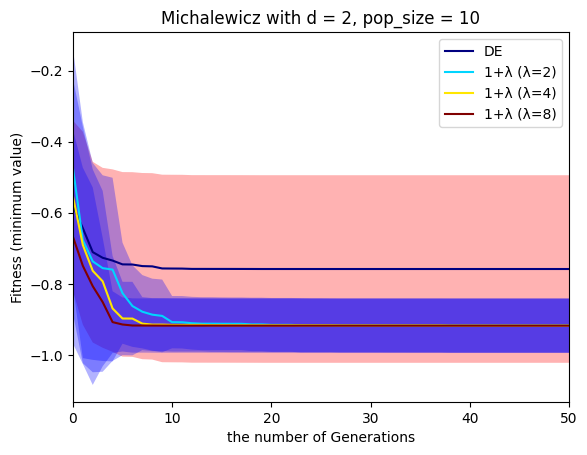

In [194]:
# Sử dụng colormap cho các giá trị 𝜆 và DE
colormap = plt.cm.get_cmap('jet', len(λ_values) + 1)

# DE
plt.plot(μ_DE_Michal1, label='DE', color=colormap(0))
plt.fill_between(np.arange(0, len(μ_DE_Michal1)), μ_DE_Michal1 - σ_DE_Michal1, μ_DE_Michal1 + σ_DE_Michal1, facecolor='r', alpha=0.3)

# (1 + λ)
for i , λ in enumerate(λ_values):
  color = colormap(i +1)
  label = f"1+λ (λ={λ})"
  plt.plot(μ_λ_Michal1[i], label=label, color=color)
  plt.fill_between(np.arange(0, len(μ_λ_Michal1[i])), μ_λ_Michal1[i] - σ_λ_Michal1[i], μ_λ_Michal1[i] + σ_λ_Michal1[i], facecolor='b', alpha=0.3)

plt.xlabel("the number of Generations")
plt.ylabel("Fitness (minimum value)")
plt.title("Michalewicz with d = 2, pop_size = 10")
plt.xlim(0, 50)
plt.legend()

**Nhận xét:**
- Khi sử dụng phương pháp DE và (1+λ)ES để tìm cực tiểu của hàm Michalewicz với kích thướt quần thể và số chiều nhỏ thì Phương pháp (1+λ)ES tỏ ra vượt trội hơn về mặt kết quả (tìm được giá trị cực tiểu) so với phương pháp DE.
- Phương pháp (1+λ)ES tìm được kết quả cuối cùng gần với giá trị cực tiểu mong đợi, còn phương pháp DE kết quả cuối cùng tìm được vẫn còn cách rất xa so với kết quả mong đợi.

In [192]:
# Bảng so sánh
data_Michal1 = []
for trial in range(n_trials):
  itemData = [ f"trial {trial + 1}", de_best_X_Michal1[trial] ]
  for i, λ in enumerate(λ_values):
    itemData.append(np.array(lambda_best_X_Michal1)[i, trial])
  data_Michal1.append(itemData)

μ_table_Michal1 = ['μ']
σ_table_Michal1 = ['σ']
for i in range(1, len(headers)):
   item = np.array(data_Michal1)[:, i]
   μ_table_Michal1.append(np.mean(item))
   σ_table_Michal1.append(np.std(item))

data_Michal1.append(μ_table_Michal1)
data_Michal1.append(σ_table_Michal1)

table_Michal1 = tabulate(data_Michal1, headers=headers, tablefmt='grid')
print(table_Michal1)

+----------+---------------------------+---------------------------+---------------------------+---------------------------+
|          | DE                        | (1+λ) λ=2                 | (1+λ) λ=4                 | (1+λ) λ=8                 |
+==========+===========================+===========================+===========================+===========================+
| trial 1  | [-1.60079436 -4.96444821] | [-4.96011685 -4.96599196] | [-4.8959039  -4.96599649] | [-4.99826741 -4.96599404] |
+----------+---------------------------+---------------------------+---------------------------+---------------------------+
| trial 2  | [-1.52085217  1.60905404] | [-2.9015746   2.20290595] | [2.34511216 2.20290429]   | [2.3733848 2.2029093]     |
+----------+---------------------------+---------------------------+---------------------------+---------------------------+
| trial 3  | [-1.82969807 -4.98403911] | [-1.79948566 -4.96603631] | [-2.6081662  -4.96600455] | [-2.24741559 -4.96601463] |


# 4.2 Michalewicz Function with **d = 10**

In [195]:
population_size = 100
d = 10
max_evaluations = 10**6

In [196]:
de_genes_best_X_collection_Michal2 = [] #  10 item trial tương ứng mỗi item là danh sách best X qua từng thế hệ (genes) i
de_genes_best_fitness_collection_Michal2 = [] # 10 item trial tương ứng mỗi item là danh sách best f qua từng thế hệ (genes) i
lambda_genes_best_X_collection_Michal2 = [] # 10 item trial tương ứng mỗi item là 1 matrix với column 1 là λ và column 2 là danh sách best X qua từng thế hệ ứng với trial và λ
lambda_genes_best_fitness_collection_Michal2 = [] # 10 trial tương ứng mỗi trial là 1 matrix với column 1 là λ và column 2 là danh sách best f qua từng thế hệ ứng với trial và λ

for trial in range(n_trials):
  np.random.seed(1039 + trial) # thiết lập random seed là 4 chữ số cuối MSHV + (0 - 9)
  pop_init = np.random.uniform(minVal, maxVal, size = (population_size, d)) # Khởi tạo cùng 1 quần thể cho cả DE và (1 + λ)ES

  # DE
  de_genes_best_X, de_genes_best_fitness = differential_evolution(michal, pop_init, minVal, maxVal, max_evaluations)
  de_genes_best_X_collection_Michal2.append(de_genes_best_X)
  de_genes_best_fitness_collection_Michal2.append(de_genes_best_fitness)

  # (1 + λ)ES
  genes_best_X_trial = [] # Mỗi Item gồm λ và genes_best_X
  genes_best_fitness_trial = [] # Mỗi Item gồm λ và genes_best_fitness
  for λ in λ_values:
    genes_best_X, genes_best_fitness = one_plus_lambda_ES(michal, pop_init, λ, minVal, maxVal, max_evaluations)
    genes_best_X_trial.append(genes_best_X)
    genes_best_fitness_trial.append(genes_best_fitness)
  lambda_genes_best_X_collection_Michal2.append(genes_best_X_trial)
  lambda_genes_best_fitness_collection_Michal2.append(genes_best_fitness_trial)

# DE: X best sau khi thuật toán chạy xong của 10 trials
de_best_X_Michal2 = np.array(de_genes_best_X_collection_Michal2)[:, -1]

# DE: Tính toán μ và σ cho đồ thị
t_DE_Michal2 = np.array(de_genes_best_fitness_collection_Michal2).T
print(t_DE_Michal2.shape)
μ_DE_Michal2 = np.mean(t_DE_Michal2, axis= 1)
σ_DE_Michal2 = np.std(t_DE_Michal2, axis=1)

# (1+λ)ES: X best sau khi thuật toán chạy xong
lambda_best_X_Michal2 = [] # Item thứ i là danh sách best X 10 trial tương ứng λ thứ i
μ_λ_Michal2 = []
σ_λ_Michal2 = []
for i, λ in enumerate(λ_values):
  best_X_items = [item[-1] for item in np.array(lambda_genes_best_X_collection_Michal2)[:, i]]
  lambda_best_X_Michal2.append(best_X_items)
  best_fitness_λ = [item for item in np.array(lambda_genes_best_fitness_collection_Michal2)[:, i]]
  t_Lambda = np.array(best_fitness_λ).T
  μ_λ_Michal2.append(np.mean(t_Lambda, axis=1))
  σ_λ_Michal2.append(np.std(t_Lambda, axis=1))

(10000, 10)


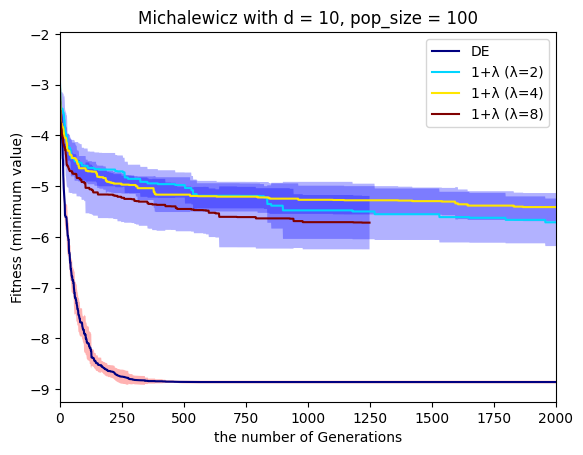

In [202]:
# Sử dụng colormap cho các giá trị 𝜆 và DE
colormap = plt.cm.get_cmap('jet', len(λ_values) + 1)

# DE
plt.plot(μ_DE_Michal2, label='DE', color=colormap(0))
plt.fill_between(np.arange(0, len(μ_DE_Michal2)), μ_DE_Michal2 - σ_DE_Michal2, μ_DE_Michal2 + σ_DE_Michal2, facecolor='r', alpha=0.3)

# (1 + λ)
for i , λ in enumerate(λ_values):
  color = colormap(i +1)
  label = f"1+λ (λ={λ})"
  plt.plot(μ_λ_Michal2[i], label=label, color=color)
  plt.fill_between(np.arange(0, len(μ_λ_Michal2[i])), μ_λ_Michal2[i] - σ_λ_Michal2[i], μ_λ_Michal2[i] + σ_λ_Michal2[i], facecolor='b', alpha=0.3)

plt.xlabel("the number of Generations")
plt.ylabel("Fitness (minimum value)")
plt.title("Michalewicz with d = 10, pop_size = 100")
plt.xlim(0, 2000)
plt.legend()

**Nhận xét:**
- có thể thấy khi sử dụng DE và (1+λ)ES để cực tiểu hóa hàm Michalewicz với kích thướt quần thể và số chiều lớn thì phương pháp DE cho kết quả tối ưu hơn và nhanh hơn phương Pháp (1+λ)ES.
- Kết quả của DE khi thuật toán chạy xong (hết 1.000.000 lần đánh giá) khi cực tiểu hóa hàm Michalewicz rất gần với kết quả mong đợi (~-9.6) còn kết quả của (1+λ)ES còn cách rất xa kết quả mong đợi.

In [198]:
# Bảng so sánh
data_Michal2 = []
for trial in range(n_trials):
  itemData = [ f"trial {trial + 1}", de_best_X_Michal2[trial] ]
  for i, λ in enumerate(λ_values):
    itemData.append(np.array(lambda_best_X_Michal2)[i, trial])
  data_Michal2.append(itemData)

μ_table_Michal2 = ['μ']
σ_table_Michal2 = ['σ']
for i in range(1, len(headers)):
   item = np.array(data_Michal2)[:, i]
   μ_table_Michal2.append(np.mean(item))
   σ_table_Michal2.append(np.std(item))

data_Michal2.append(μ_table_Michal2)
data_Michal2.append(σ_table_Michal2)

table_Michal2 = tabulate(data_Michal2, headers=headers, tablefmt='grid')
print(table_Michal2)

+----------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------------+
|          | DE                                                                       | (1+λ) λ=2                                                                | (1+λ) λ=4                                                                | (1+λ) λ=8                                                                |
+==========+==========================================================================+==========================================================================+==========================================================================+==========================================================================+
| trial 1  | [-0.77537263 -4.96599769  1.57079633 -4.96714945